# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
* `/datasets/geo_data_0.csv.` 
* `/datasets/geo_data_1.csv.` 
* `/datasets/geo_data_2.csv.` 
* *id* — уникальный идентификатор скважины;
* *f0*, *f1*, *f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
* *product* — объём запасов в скважине (тыс. баррелей).

# Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Необходимые библиотеки

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split
)
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from numpy.random import RandomState
from IPython.display import HTML, display as display_html

## Загрузка и подготовка данных

**Загрузка данных про трём регионам**

In [ ]:
geo_data0 = pd.read_csv('./geo_data_0.csv')
geo_data1 = pd.read_csv('./geo_data_1.csv')
geo_data2 = pd.read_csv('./geo_data_2.csv')
geo_datas = []
geo_datas.append(geo_data0)
geo_datas.append(geo_data1)
geo_datas.append(geo_data2)
geo_data_names = ['geo_data0.csv', 'geo_data1.csv', 'geo_data2.csv']

Функция для оформления вывода

In [3]:
def show_html(text, color='#E9ECEF'):
    from IPython.display import HTML, display
    display(HTML(f'<span style="background-color: {color};">{text}</span>'))

**Вывод первых строк каждого файла**

In [4]:
for i, geo_data in enumerate(geo_datas):
    show_html(geo_data_names[i])
    display(geo_data.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные загружены правильно

**Провека наличия пропусков в данных**

In [5]:
for i, geo_data in enumerate(geo_datas):
    show_html(geo_data_names[i])
    display(geo_data.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропусков в данных нет

**Провека наличия явных дупликатов**

In [6]:
for i, geo_data in enumerate(geo_datas):
    show_html(geo_data_names[i])
    display(geo_data.duplicated().sum())

0

0

0

Явных дупликатов нет

**Проверка статистических метрик для непрерывных количественных признаков**

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


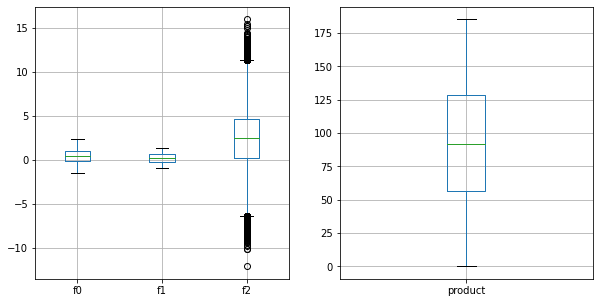

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


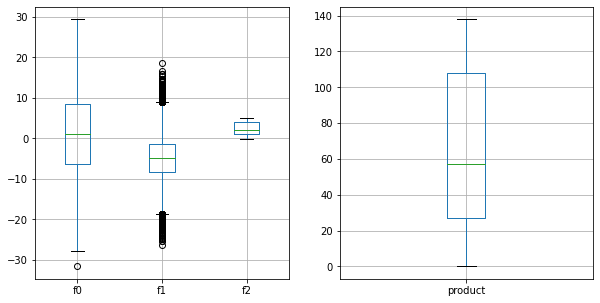

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


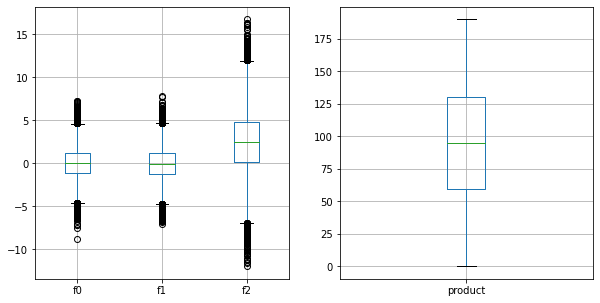

In [7]:
for i, geo_data in enumerate(geo_datas):
    show_html(geo_data_names[i])
    display(geo_data.drop(['id'], axis=1).describe())
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    geo_data.boxplot(column=['f0', 'f1', 'f2'])
    plt.subplot(1, 2, 2)
    geo_data.boxplot(column='product')
    plt.show()

В таблице `geo_data0.csv` есть явные выбросы в столбце `f2`, т. е. значения признака, находящиеся на большем расстоянии от медианы, чем на полтора интерквартильных размаха. 

В таблице `geo_data1.csv` присутствуют множественные выбросы в столбце `f1`.

В таблице `geo_data2.csv` множественные выбросы есть во всех трёх признаках.

Выбросов большое количество, удалять их не можем.

**Проверка уникальность значений в поле `id`**

In [8]:
for i, geo_data in enumerate(geo_datas):
    show_html(geo_data_names[i])
    print('Число неуникальных id =', geo_data['id'].duplicated().sum())
    print()
    print('Строки с неуникальными id:')
    bad_ids = (geo_data['id']
               .value_counts()
    .sort_values(ascending=False).
    head(geo_data['id'].duplicated().sum())
               .index
              )
    display(geo_data[geo_data['id'].isin(bad_ids)].sort_values(by='id'))
    print('Удаляем строки с неуникальными id')
    print()
    geo_datas[i] = geo_datas[i][~geo_datas[i]['id'].isin(bad_ids)]
    print(f'Размер geo_data{i}.csv: {geo_datas[i].shape}')
    print()
    print('Число неуникальных id после удаления:',\
          geo_datas[i]['id'].duplicated().sum())
    print()

Число неуникальных id = 10

Строки с неуникальными id:


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Удаляем строки с неуникальными id

Размер geo_data0.csv: (99980, 5)

Число неуникальных id после удаления: 0



Число неуникальных id = 4

Строки с неуникальными id:


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Удаляем строки с неуникальными id

Размер geo_data1.csv: (99992, 5)

Число неуникальных id после удаления: 0



Число неуникальных id = 4

Строки с неуникальными id:


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Удаляем строки с неуникальными id

Размер geo_data2.csv: (99992, 5)

Число неуникальных id после удаления: 0



Дупликаты в поле `id` удалены

**Проверка распределений непрерывных количественных признаков**

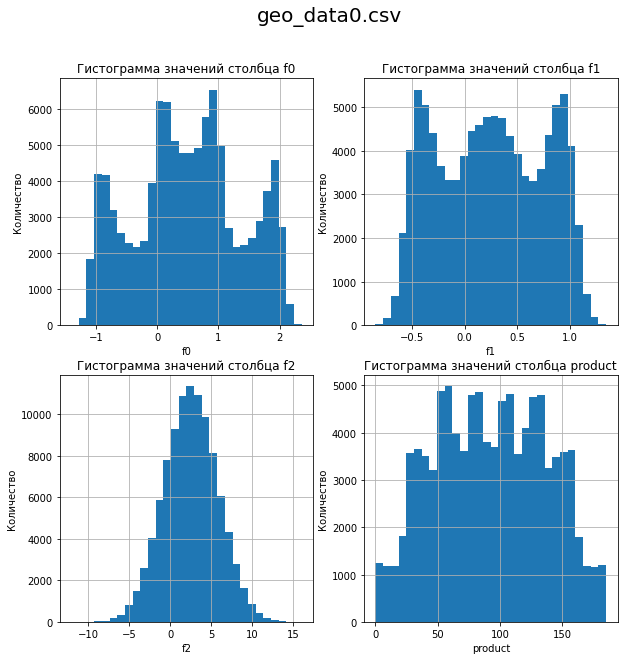

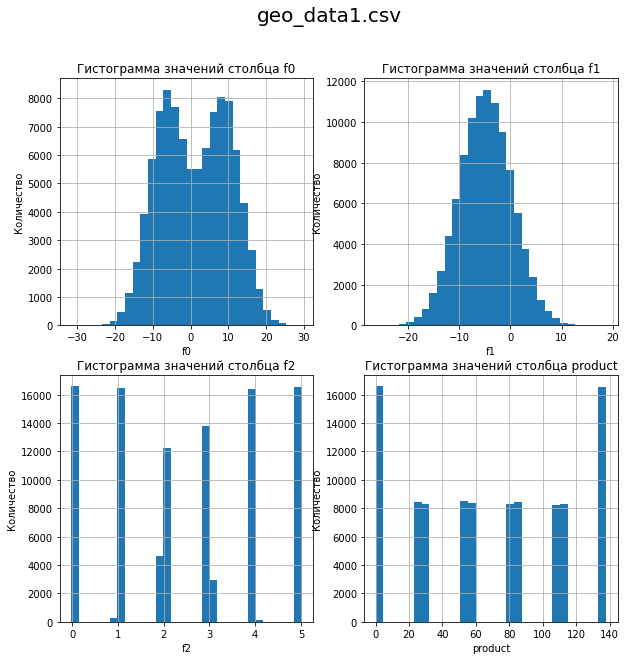

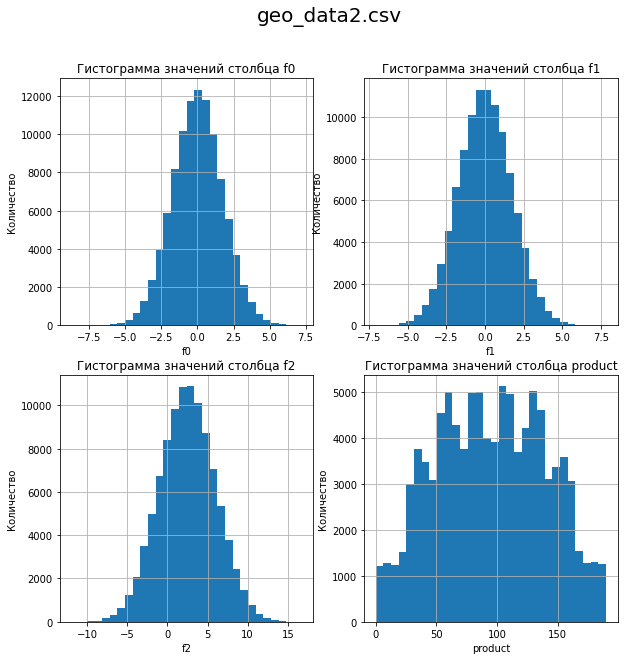

In [9]:
for i, geo_data in enumerate(geo_datas):
    curr_data = geo_data.drop(['id'], axis=1)
    columns = curr_data.columns
    fig = plt.figure(figsize=(10, 10))
    plt.suptitle(geo_data_names[i], fontsize=20)
    for i, column in enumerate(columns):
        plt.subplot(2, 2, i+1)
        plt.hist(curr_data[column], bins=30)
        plt.title('Гистограмма значений столбца '+ column)
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
    plt.show()

Визуально на графиках не получается выделить выбросы, а также не все распределения имеют вид нормальных.

**Вывод:**
* Данные загружены
* Проверено отстуствие пропусков и явных дупликатов
* Удалены строки с неуникальными `id`
* Выявлены выбросы в данных и визуализированы распределения признаков


## Обучение и проверка модели

Параметр для воспроизводимости разделения данных

In [10]:
RANDOM_STATE = 42

Функция для разделения выборки на тренировочную и валидационную, обучения на тренировочной и проверки на валидационной выборках

In [11]:
def TrainAndValid(data):
    # Выделение целевого признака
    X = data.drop(['id', 'product'], axis=1)
    y = data['product']
    
    # Разделение на тренировочную и валидационную выборки
    X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    
    # Обучение модели линейной регрессии и предсказание
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)

    print('Средний запас предсказанного сырья:', y_valid_pred.mean())
    print('RMSE модели =', \
          mean_squared_error(y_valid, y_valid_pred, squared=False))
    return y_valid, y_valid_pred, X_valid

In [12]:
y_valid = []
y_valid_pred = []
X_valid = []
for i, geo_data in enumerate(geo_datas):
    show_html(geo_data_names[i])
    y_valid_curr, y_valid_pred_curr, X_valid_curr = TrainAndValid(geo_data)
    y_valid.append(y_valid_curr)
    y_valid_pred.append(y_valid_pred_curr)
    X_valid.append(X_valid_curr)

Средний запас предсказанного сырья: 92.2865385223536
RMSE модели = 37.76114714593895


Средний запас предсказанного сырья: 69.16894101447983
RMSE модели = 0.8928635898777318


Средний запас предсказанного сырья: 94.82069136328788
RMSE модели = 40.13115560413051


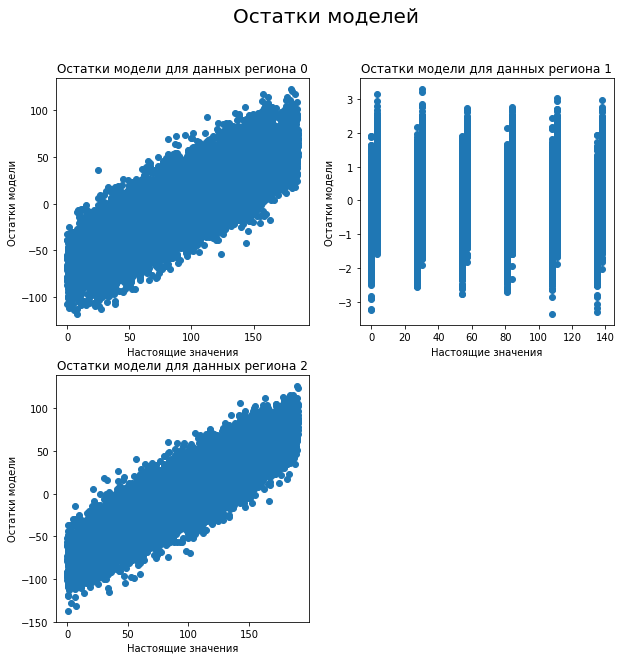

In [20]:
residuals = []
fig = plt.figure(figsize=(10, 10))
plt.suptitle('Остатки моделей', fontsize=20)
for i, geo_data in enumerate(geo_datas):
    residuals.append(y_valid[i] - y_valid_pred[i])
    plt.subplot(2, 2, i+1)
    plt.scatter(y_valid[i], residuals[i])
    plt.xlabel('Настоящие значения')
    plt.ylabel('Остатки модели')
    plt.title('Остатки модели для данных региона '+str(i))

Вывод:

Регионы `0` и `2` обладают высоким средним запасом предсказанного сырья, что сильно выделяет их на фоне региона `1` (примерно на 40% больше предсказанного сырья). Для региона `1` построенная модели работает в разы точнее (среднеквадратичная ошибка отличается в более чем 40 раз).

Также из анализа остатков визуально видно, что разброс ошибок модели `1` одинаков для всех реальных значений. Для моделей, обученных и валидированных на данных из регионов `0` и `2`, свойственно сильное завышение предсказаний сырья для низких реальных значений и заметное занижение пресказаний сырья для высоких реальных значений количества сырья.

## Подготовка к расчёту прибыли

Ключевые значения для расчетов

In [13]:
N_POINTS = 500 # количество точек для разведки
N_BEST_POINTS = 200 # количество точек для разработки
BUDGET = 10 * 10**9 # бюджет на разработку скаважин в регионе
COST = 450000 # доход с единицы продукта
PERCENTAGE = 2.5 # порог вероятности убытков для выбора региона

Расчет достаточного объема сырья для безубыточной разработки новой скважины

In [14]:
one_well_budget = BUDGET / N_BEST_POINTS
sufficient_product = one_well_budget / COST
print('Для безубыточной разработки новой скважины достаточно', \
     round(sufficient_product, 2), 'сырья')

Для безубыточной разработки новой скважины достаточно 111.11 сырья


Вывод:
Полученное значение `111.11` единиц сырья превосходит средние значения по регионам (`92.29`, `69.17` и `94.82`). Это означает, что при случайном выборе лучших `200` скважин из `500` и без того случайно выбранных, мы в более чем `50%` случаев будем получать отрицательную прибыль и, конечно, не получим вероятность убытков ниже `2.5%`. Эту проблему необходимо решать при помощи выбора наилучших скважин из `500` случайно выбранных, чтобы среднее число сырья в этих `200` оказывалось больше, чем `111.11` в более чем `97.5%` случаев.

## Расчёт прибыли и рисков 

Функция для расчета прибыли от региона

In [15]:
def calculate_profit(df):
    # выбор 200 скважин с наибольшими значениями предсказаний
    best_df = df.sort_values(by='product_pred', ascending=False)\
    .head(N_BEST_POINTS)
    # вычисление общего объема сырья для настоящих объемов сырья этих скважин
    total_product = best_df['product_true'].sum()
    # расчет прибыли для полученного объема сырья
    profit = total_product * COST - BUDGET
    return profit

**Расчет прибыли и рисков**

Поиск распределения прибыли с помощью Bootstrap для 1000 выборок

In [16]:
valid_data = []
for i in range(3):
    valid_data_curr = X_valid[i].copy()
    valid_data_curr['product_pred'] = y_valid_pred[i]
    valid_data_curr['product_true'] = y_valid[i]
    valid_data.append(valid_data_curr)

In [17]:
state = RandomState(12345)
values = []
profits = []

for i, geo_data in enumerate(geo_datas):
    profits.append([])
    for j in range(1000):
        subsample = valid_data[i].sample(n=500, replace=True, random_state=state)
        curr_profit = calculate_profit(subsample)
        profits[i].append(curr_profit)

**Расчет средней прибыли, доверительного интервала и риска убытков**

In [18]:
for i, geo_data in enumerate(geo_datas):
    show_html(geo_data_names[i])
    
    # Средняя прибыль
    print(f'Средняя прибыль = {sum(profits[i])/len(profits[i]):.2f}')
    
    # 95%-й доверительный интервал
    profits[i] = pd.Series(profits[i])
    lower = profits[i].quantile(0.05)
    upper = profits[i].quantile(0.95)
    print(f'95%-й доверительный интервал: ({lower:.2f}, {upper:.2f})')
    
    # Риск убытков
    probability = (profits[i]<0).mean()
    print('Вероятность убытков =', probability)

Средняя прибыль = 396713209.98
95%-й доверительный интервал: (-35282631.09, 810748143.63)
Вероятность убытков = 0.072


Средняя прибыль = 483529594.86
95%-й доверительный интервал: (154850499.74, 815502917.55)
Вероятность убытков = 0.009


Средняя прибыль = 356796976.77
95%-й доверительный интервал: (-73944170.38, 801568148.30)
Вероятность убытков = 0.1


**Итоговый вывод:**
* Данные по трём регионам для добычи нефти были загружены, а также был проведен их статистический анализ.
* На данных по нефтяным скважинам каждого из регионов была обучена модель линейной регрессии. В регионах `0` и `2` модель показала наибольшие средние предсказания количества сырья (примерно на 40% больше, чем в регионе `1`). Модель для скважин региона `1` продемонстрировала примерно в 50 раз лучшую точность предсказаний, чем в регионах `0` и `2`.
* Был рассчитан достаточный объем сырья для безубыточной разработки новой скважины. Этот объем оказался больше, чем средний объем в каждой из скважин, из чего был сделан вывод о важности выбора 200 лучших скважин из 500 выбранных для рассмотрения.
* Была написана функция для расчета прибыли по выбранным скважинам и предсказания модели. Функция выбирала из 500 скважин 200 скважин с лучшими предсказанными значениями количества сырья. Для этих 200 скважин суммировались настоящие значения количества сырья. Итоговое количество сырья умножалось на стоимость тысячи баррелей и из него вычитался бюджет освоения региона.
* С помощью технологии *Bootstrap* с 1000 выборок было найдено распределение прибыли. По полученному распределению был построен 95%-й доверительный интервал и вероятность убытков.
* С учетом проведенного анализа под требования заказчиков подходит только регион `1`, несмотря на то, что на первых этапах анализа модель для этого региона имела наименьшие средние предсказания, хотя и наилучшую точность.
* Получились следующие оценки распределения прибыли:
    - Средняя прибыль = 483529594.85
    - 95%-й доверительный интервал: (154850499.74, 815502917.55)
    - Вероятность убытков = 0.009
* Для разработки рекомендуетсся регион `1`